# Simulate Dreamer

simulate the loop with 
* get action from z with Controller and RNN
* step:
  * sample next z with RNN
  * done= False until certain level of steps is reached
  * reward = 0 - always

In [1]:
import numpy as np
import tensorflow as tf
import os 
import json
import numpy as np
from gym.envs.atari.atari_env import AtariEnv
from gym.spaces.box import Box
from gym.utils import seeding
from PIL import Image

In [2]:
import sys
from pathlib import Path
path = str(Path(os.getcwd()).parent.parent)
sys.path.insert(0, path)

from breakout.vae.vae import ConvVAE
from breakout.rnn.rnn import RNNModel, hps_sample, rnn_init_state, rnn_next_state, rnn_output, rnn_output_size

In [3]:
load_model = True
rnn_path='/home/student/Dropbox/MA/worldmodel/worldmodel-breakout-server-version-v2/200228/tf_rnn_10000/rnn.json'
vae_path='/home/student/Dropbox/MA/worldmodel/worldmodel-breakout-server-version-v2/200228/tf_vae/vae.json'

file = '/home/student/Dropbox/MA/worldmodel/worldmodel-breakout-server-version-v2/200228/log/breakout.cma.16.64.best.json'

num_episode = 1
frame_limit = 500

In [4]:
SCREEN_X = 64
SCREEN_Y = 64
FACTOR = 3

In [5]:
with open(os.path.join('/home/student/Dropbox/MA/worldmodel/worldmodel-breakout-server-version-v2/200228/tf_initial_z', 'initial_z.json'), 'r') as f:
    [initial_mu, initial_logvar] = json.load(f)

initial_mu_logvar = [list(elem) for elem in zip(initial_mu, initial_logvar)]

In [6]:
seq_length = num_episode*frame_limit+1
img_sequence = np.zeros(shape=(seq_length,64,64,3))

In [7]:
def get_pi_idx(x, pdf):
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    print('error with sampling ensemble')
    return -1

In [8]:
class BreakoutDream(AtariEnv):
    metadata = {
        'render.modes':['human', 'rgb_array']
    }
    def __init__(self, agent, frame_limit):
        self.observation_space = Box(low=0, high=255., shape=(64,64,3))
        self.agent = agent
        self.vae = agent.vae
        self.rnn = agent.rnn
        self.z_size = self.rnn.hps.encoded_img_width
        self.viewer = None
        self.frame_count = None
        self.frame_limit = frame_limit
        self.z = None
        self.temperature = 0.7
        self.seq_counter=0

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _sample_next_z(self, action):
        r_model = self.rnn
        temp = self.temperature

        sess = r_model.sess
        hps = r_model.hps

        prev_x = np.zeros((1, 1, self.z_size))
        prev_x[0][0] = self.z

        input_x = np.concatenate((prev_x, action.reshape(1, 1, 4)), axis=2)
        feed = {
            r_model.input_x : input_x,
            r_model.initial_state: self.agent.state
        }
        [logmix, mean, logstd, self.agent.state] = sess.run(
            [r_model.out_logmix, r_model.out_mean, r_model.out_logstd, r_model.final_state], feed)

        # adjust temperatures
        logmix2 = np.copy(logmix) / temp
        logmix2 -= logmix2.max()
        logmix2 = np.exp(logmix2)
        logmix2 /= logmix2.sum(axis=1).reshape(self.z_size, 1)

        mixture_idx = np.zeros(self.z_size)
        chosen_mean = np.zeros(self.z_size)
        chosen_logstd = np.zeros(self.z_size)
        for j in range(self.z_size):
            idx = get_pi_idx(self.np_random.rand(), logmix2[j])
            mixture_idx[j] = idx
            chosen_mean[j] = mean[j][idx]
            chosen_logstd[j] = logstd[j][idx]

        rand_gaussian = self.np_random.randn(self.z_size)*np.sqrt(temp)
        next_x = chosen_mean + np.exp(chosen_logstd)*rand_gaussian

        next_z = next_x.reshape(self.z_size)

        return next_z

    def _reset(self):
        idx = self.np_random.randint(0,len(initial_mu_logvar))
        init_mu, init_logvar = initial_mu_logvar[idx]
        init_mu = np.array(init_mu)/10000.
        init_logvar = np.array(init_logvar)/10000.

        self.z = init_mu + np.exp(init_logvar/2.0) * self.np_random.randn(*init_logvar.shape)

        self.frame_count = 0
        return self.z

    def _step(self, action_one_hot):
        self.frame_count += 1
        next_z = self._sample_next_z(action_one_hot)
        reward = 0
        done = False
        if self.frame_count > self.frame_limit:
            done = True
        self.z = next_z
        return next_z, reward, done, {}

    def _render(self, mode='human', close = False):
        img = self.vae.decode(self.z.reshape(1, self.z_size))*255.
        img = np.round(img).astype(np.uint8)
        img = img.reshape(64,64,3)
        
        seq_counter = self.seq_counter
        img_sequence[seq_counter,:,:,:] = img
        seq_counter+=1
        self.seq_counter = seq_counter

        img = Image.fromarray(img)
        img_resize = img.resize(size=(int(np.round(SCREEN_Y*FACTOR)), int(np.round(SCREEN_X*FACTOR))))
        img_resize = np.array(img_resize)

        if close:
            if self.viewer is not None:
                self.viewer.close()
                self.viewer = None
            return

        if mode == 'rgb_array':
            return img_resize
        elif mode == 'human':
            from gym.envs.classic_control import rendering
            if self.viewer is None:
                self.viewer = rendering.SimpleImageViewer()
            self.viewer.imshow(img_resize)

In [9]:
def make_env(env_name, agent, frame_limit, seed=-1, render_mode = False):
    env = BreakoutDream(agent, frame_limit)
    if seed<0:
        seed = np.random.randint(2**31-1)
    env.seed(seed)
    return env

In [10]:
def softmax(x):
    return np.exp(x)/ np.sum(np.exp(x), axis=0)

In [11]:
class DreamModel():
    def __init__(self, load_model=True,   rnn_path='tf_rnn/rnn.json', vae_path='tf_vae/vae.json', frame_limit=1200):
        self.env_name = 'Breakout-v0'

        self.vae = ConvVAE(batch_size=1, gpu_mode=False, is_training=False, reuse=True)
        self.rnn = RNNModel(hps_sample, gpu_mode=False, reuse=True)

        if load_model:
            self.vae.load_json(vae_path)  # vae_path)
            self.rnn.load_json(rnn_path)

        self.frame_limit=frame_limit
        self._make_env()

        self.state = rnn_init_state(self.rnn)
        self.rnn_mode = True

        self.input_size = rnn_output_size()
        self.z_size = 32

        self.render_mode = False

    def _make_env(self, seed=-1, render_mode =False):
        self.render_mode = render_mode
        self.env = make_env(self.env_name, agent = self, frame_limit= self.frame_limit, seed = seed)

    def reset(self):
        self.state = rnn_init_state(self.rnn)

    def encode_obs(self, obs):
        result = np.expand_dims(obs, axis=0)
        mu, logvar = self.vae.encode_mu_logvar(result)
        mu = mu[0]
        logvar = logvar[0]
        s = logvar.shape
        z = mu + np.exp(logvar / 2.0) * np.random.randn(*s)
        return z, mu, logvar

    def get_action(self, z):
        h = rnn_output(self.state, z)
        action = softmax(np.matmul(h, self.weight) + self.bias)
        action = np.argmax(action)
        action_one_hot = np.zeros(self.rnn.hps.num_actions)
        action_one_hot[action] = 1
        self.state = rnn_next_state(self.rnn, z, action_one_hot, self.state)
        return action_one_hot, action

    def set_model_params(self, model_params):
        self.bias = np.array(model_params[:4])
        self.weight = np.array(model_params[4:]).reshape(self.input_size, 4)

    def load_model(self, filename):
        with open(filename) as f:
            data = json.load(f)
        print('loading file %s' % (filename))
        self.data = data
        model_params = np.array(data[0])  # assuming other stuff is in data
        self.set_model_params(model_params)

In [12]:
model = DreamModel(load_model, rnn_path, vae_path, frame_limit=frame_limit)

INFO:tensorflow:Model using cpu.


In [13]:
model.load_model(file)

loading file /home/student/Dropbox/MA/worldmodel/worldmodel-breakout-server-version-v2/200228/log/breakout.cma.16.64.best.json


In [14]:
def simulate(model, train_mode=False, render_mode=False, num_episode=1, seed=-1, max_len=-1):
    reward_list = []
    t_list= []
    action_list = []
    z_sumsquare = []
    max_episode_length = 2100

    if max_len>0:
        max_episode_length = max_len

    if (seed >= 0):
        random.seed(seed)
        np.random.seed(seed)
        model.env.seed(seed)

    for episode in range(num_episode):
        model.reset()
        z = model.env.reset()

        for t in range(max_episode_length):
            action_one_hot, action = model.get_action(z)
            action_list.append(action)

            if render_mode:
                model.env.render('human')
            else:
                model.env.render('rgb_array')


            z, reward, done, info = model.env.step(action_one_hot) # two problems here: where to get reward and done info ?
            z_sumsquare.append(np.sum(np.square(z)))

            if done:
                model.env.viewer.close()
                model.env.viewer = None
                break
        t_list.append(t)

    return reward_list, t_list, action_list, z_sumsquare

In [15]:
reward, steps_taken, action_list, z_sumsquare = simulate(model, train_mode=False, render_mode=True, num_episode=num_episode)
print('terminal reward: ', reward, ' ,average steps taken: ', np.mean(steps_taken)+1)

terminal reward:  []  ,average steps taken:  501.0


## Auswertung

In [16]:
import matplotlib.pyplot as plt

Action Distribution

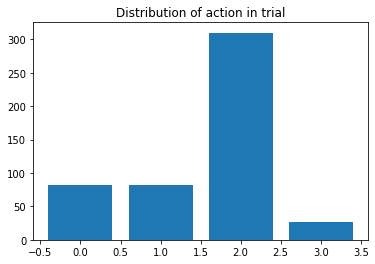

In [17]:
set_action = set(action_list)
action_counted = []
for action_elem in set_action:
    action_counted.append(action_list.count(action_elem))

plt.bar(list(set_action), action_counted)
plt.title('Distribution of action in trial')
plt.show()

Evolving z

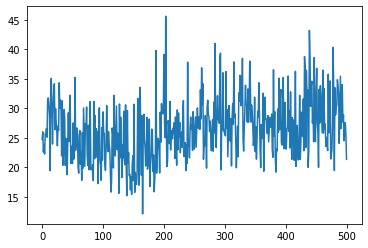

In [18]:
plt.plot(z_sumsquare)
plt.show()

Video Sequence

In [19]:
import base64
import imageio
import IPython

In [20]:
def embed_mp4(filename,video):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="400" height="300" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [21]:
np.array_equal(img_sequence[5], img_sequence[6])

False

In [22]:
filename = 'simulate_sequence_200228.mp4'
with imageio.get_writer(filename, mode='I', macro_block_size=None) as video:    
    for image in range(len(img_sequence)):
        video.append_data(img_sequence[image].astype(np.uint8))
embed_mp4(filename,video)